In [27]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from pandas import *
import pandas as pd
import numpy as np
from IPython.display import display
pd.set_option('notebook_repr_html', False )


import seaborn as sns
sns.set_context("talk", rc={"lines.linewidth": 2.0})
sns.set_style("darkgrid")


pd.set_option('precision', 4)

In [3]:
# Check the structure of the data file
pd.read_csv('ch02/names/yob1882.txt').head()

        Mary  F  8149
0       Anna  F  3143
1       Emma  F  2303
2  Elizabeth  F  2187
3     Minnie  F  2004
4   Margaret  F  1821

        name sex  births  year
0       Mary   F    7065  1880
1       Anna   F    2604  1880
2       Emma   F    2003  1880
3  Elizabeth   F    1939  1880
4     Minnie   F    1746  1880
sex         F        M
year                  
2006  1896468  2050234
2007  1916888  2069242
2008  1883645  2032310
2009  1827643  1973359
2010  1759010  1898382


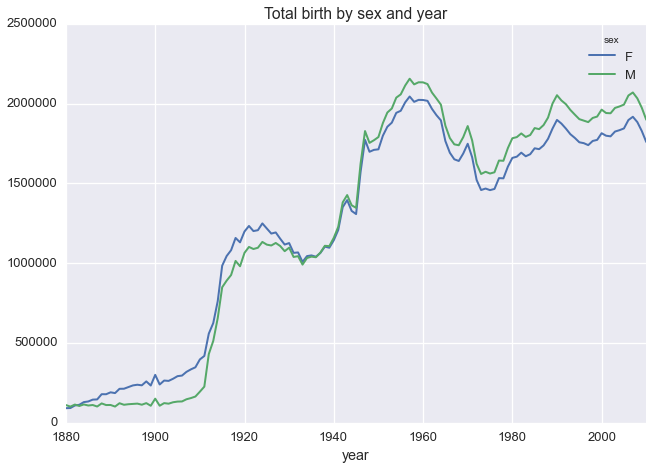

In [5]:
# Notice the datafiles in the directory structure are in the form
# 'yob1880.txt' to 'yob2010.txt'. We can use it to set iterations.

path = ''
bk_columns = ['name', 'sex', 'births'] 
years = range(1880,2011)
pieces = []

for yr in years:
    path = 'ch02/names/yob%d.txt' %yr
    dframe = pd.read_csv(path, names=bk_columns)

    # Add new 'year' column already set in range above.
    dframe['year'] = yr
    pieces.append(dframe)
    

# Concatenate all rows from diff pieces into a single Dataframe.
# set 'ignore_index = True': to not preserve original row numbers.

bk_names = pd.concat(pieces, ignore_index=True)
print(bk_names.head())


total_births = bk_names.pivot_table('births', index='year', columns='sex', aggfunc=sum)

# Print last 5 rows and plot 
print;print
print(total_births.tail(5))
total_births.plot(title='Total birth by sex and year')



In [29]:
# After groupby, a group is a sub-division that's created.
# Each group can be taken, modified, and then re-joined.

def add_prop(group):
    #Integer division floors
    births = group.births.astype(float)
    
    group['prop'] = births / births.sum()
    return group


bk_names = bk_names.groupby(['year', 'sex']).apply(add_prop)
bk_names.head()

        name sex  births  year   prop
0       Mary   F    7065  1880  0.078
1       Anna   F    2604  1880  0.029
2       Emma   F    2003  1880  0.022
3  Elizabeth   F    1939  1880  0.021
4     Minnie   F    1746  1880  0.019

In [31]:
# To ensure the group sum is sufficiently close to 1.
np.allclose(bk_names.groupby(['year', 'sex']).prop.sum(), 1)


True

In [32]:
# Extract first 1,000 of the names from each group

def get_topX000(group, how_many):
    return group.sort_index(by='births', ascending=False)[:how_many]


top_thousands = bk_names.groupby(['year', 'sex']).apply(get_topX000, 1000);

In [33]:
boys = top_thousands[top_thousands.sex=='M']

girls = top_thousands[top_thousands.sex=='F']

total_births = top_thousands.pivot_table('births', index='year', columns='name', aggfunc=sum);

total_births.head()

name  Aaden  Aaliyah  Aarav  Aaron  Aarush  Ab  Abagail  Abb  Abbey  Abbie  \
year                                                                         
1880    NaN      NaN    NaN    102     NaN NaN      NaN  NaN    NaN     71   
1881    NaN      NaN    NaN     94     NaN NaN      NaN  NaN    NaN     81   
1882    NaN      NaN    NaN     85     NaN NaN      NaN  NaN    NaN     80   
1883    NaN      NaN    NaN    105     NaN NaN      NaN  NaN    NaN     79   
1884    NaN      NaN    NaN     97     NaN NaN      NaN  NaN    NaN     98   

name  ...   Zoa  Zoe  Zoey  Zoie  Zola  Zollie  Zona  Zora  Zula  Zuri  
year  ...                                                               
1880  ...     8   23   NaN   NaN     7     NaN     8    28    27   NaN  
1881  ...   NaN   22   NaN   NaN    10     NaN     9    21    27   NaN  
1882  ...     8   25   NaN   NaN     9     NaN    17    32    21   NaN  
1883  ...   NaN   23   NaN   NaN    10     NaN    11    35    25   NaN  
1884  ...    13

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1119f9c50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1126a58d0>], dtype=object)

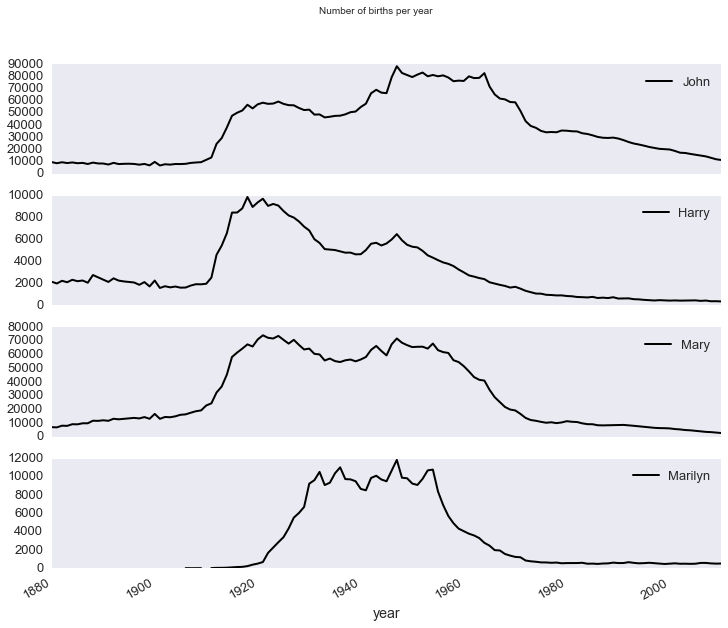

In [36]:
subset = total_births[['John','Harry', 'Mary', 'Marilyn']]

subset.plot(subplots=True, figsize=(12,10), grid=False, title='Number of births per year')

Data above may suggest fewer parents are choosing common names for their children. Can the hypothesis be proved?

## Measuring increase in naming diversity

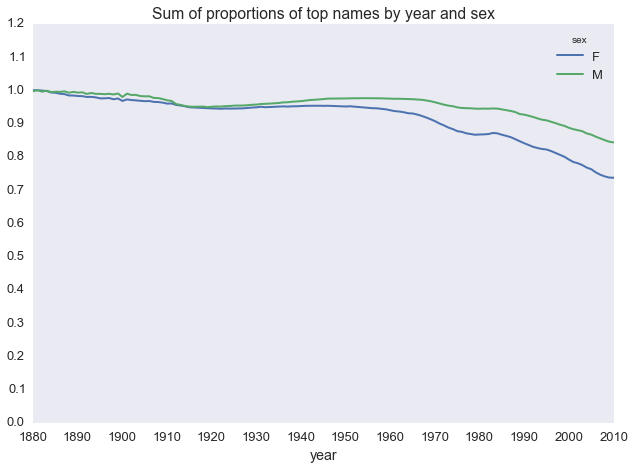

In [44]:
births_table = top_thousands.pivot_table('prop', index='year', columns='sex', aggfunc=sum)

births_table.plot(title='Sum of proportions of top names by year and sex', grid=False,
                 yticks= np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))

In [97]:
df = boys[boys.year == 1900]

prop_cumsum = df.sort_index(by='prop', ascending=False).prop.cumsum()

# Find proportion of birth in 1900. Since arrays are zero indexed, we need to add 1 to results.
pcsum = prop_cumsum.searchsorted(0.5) + 1

int(pcsum)


25

sex    F   M
year        
1880  38  14
1881  38  14
1882  38  15
1883  39  15
1884  39  16


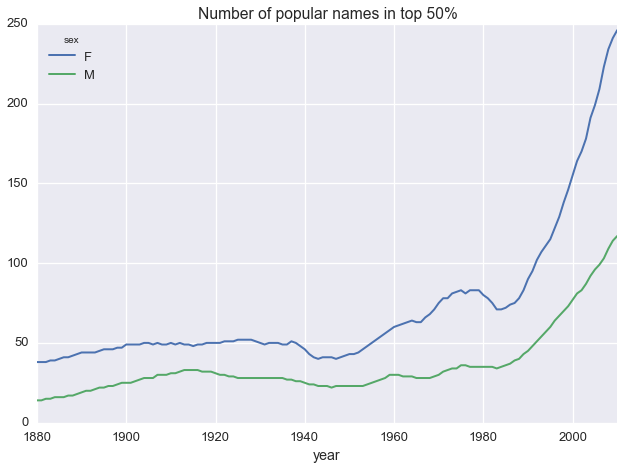

In [111]:
def get_quantile_count(group, q=0.5):
    group = group.sort_index(by='prop', ascending=False)
    return int(group.prop.cumsum().searchsorted(q) + 1)

diversity = top_thousands.groupby(['year', 'sex']).apply(get_quantile_count)

divs = diversity.unstack('sex')

print(divs.head())

divs.plot(title='Number of popular names in top 50%')

## Last Letter Revolution

To show that the distribution of baby boys' names have changed over the last 100 years.

In [126]:
# Extract last letter from name column

get_last_letter = lambda x: x[-1]
last_letters = bk_names.name.map(get_last_letter)
last_letters.name = 'last_letter'

table = bk_names.pivot_table('births', index=last_letters, columns=['sex', 'year'], aggfunc=sum)

table.head(2)

sex              F                                                          \
year          1880   1881   1882   1883   1884   1885   1886   1887   1888   
last_letter                                                                  
a            31446  31581  36536  38330  43680  45408  49100  48942  59442   
b              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

sex                 ...        M                                            \
year          1889  ...     2001   2002   2003   2004   2005   2006   2007   
last_letter         ...                                                      
a            58631  ...    39124  38815  37825  38650  36838  36156  34654   
b              NaN  ...    50950  49284  48065  45914  43144  42600  42123   

sex                               
year          2008   2009   2010  
last_letter                       
a            32901  31430  28438  
b            39945  38862  38859  

[2 rows x 262 columns]

### Select representative years spanning the history and print first few rows:

In [130]:
# Select representative years spanning the history and print first few rows:

subtable = table.reindex(columns=[1910, 1960, 2010], level='year')

subtable.head()

sex               F                      M                
year           1910    1960    2010   1910    1960    2010
last_letter                                               
a            108376  691247  670605    977    5204   28438
b               NaN     694     450    411    3912   38859
c                 5      49     946    482   15476   23125
d              6750    3729    2607  22111  262112   44398
e            133569  435013  313833  28655  178823  129012

### Normalize the table by total births

In [139]:
print(subtable.sum())

letter_prop = subtable / subtable.sum().astype(float)

letter_prop.head()

sex  year
F    1910     396416
     1960    2022062
     2010    1759010
M    1910     194198
     1960    2132588
     2010    1898382
dtype: float64


sex                  F                            M              
year              1910       1960       2010   1910   1960   2010
last_letter                                                      
a            2.734e-01  3.419e-01  3.812e-01  0.005  0.002  0.015
b                  NaN  3.432e-04  2.558e-04  0.002  0.002  0.020
c            1.261e-05  2.423e-05  5.378e-04  0.002  0.007  0.012
d            1.703e-02  1.844e-03  1.482e-03  0.114  0.123  0.023
e            3.369e-01  2.151e-01  1.784e-01  0.148  0.084  0.068

### With the letter proportions, we can make bar plot for each sex broken by years

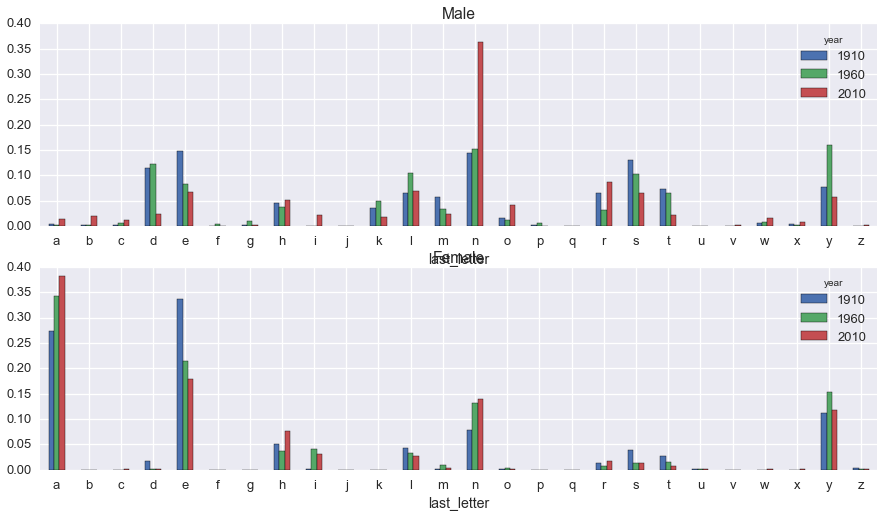

In [149]:
fig, axes = plt.subplots(2,1, figsize=(15,8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')

letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female')

Since the `1960`, `boys` names ending with `n` have experience growth. Same for `girls` names ending in `a`. However, `girls` names ending in `e` declined from `1910` to `2010`.

### Select letter with significance and visualize the time series.

In [164]:
letter_prop = table / table.sum().astype(float)
dny_ts_boys = letter_prop.ix[['d', 'n', 's', 'y'], 'M'].T
aeny_ts_girls = letter_prop.ix[['a', 'e', 'n', 'y'], 'F'].T

print(dny_ts_boys.head())
print('\n')
print(aeny_ts_girls.head())

last_letter      d      n      s      y
year                                   
1880         0.083  0.153  0.167  0.076
1881         0.083  0.153  0.162  0.077
1882         0.085  0.150  0.160  0.078
1883         0.084  0.152  0.158  0.079
1884         0.086  0.150  0.155  0.080


last_letter      a      e      n      y
year                                   
1880         0.346  0.367  0.033  0.115
1881         0.343  0.371  0.032  0.113
1882         0.339  0.375  0.033  0.113
1883         0.341  0.373  0.034  0.107
1884         0.339  0.373  0.035  0.108


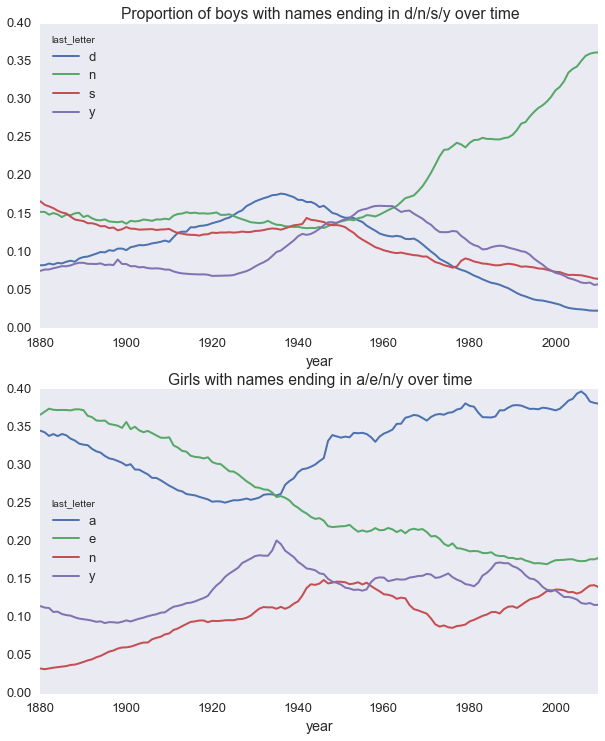

In [173]:
fig, axes = plt.subplots(2,1, figsize=(10,12))
dny_ts_boys.plot(ax=axes[0], title='Proportion of boys with names ending in d/n/s/y over time', grid=False)
aeny_ts_girls.plot(ax=axes[1], title='Girls with names ending in a/e/n/y over time', grid=False)



## Boys names that became girls names (and vice versa)

Example is name `Lesley` that became `Leslie`

In [182]:
all_names = top_thousands.name.unique()

mask = np.array(['lesl' in x.lower() for x in all_names])

lesley_like = all_names[mask]

lesley_like


array(['Leslie', 'Lesley', 'Leslee', 'Lesli', 'Lesly'], dtype=object)

### We filter to those `X` names and sum of their births then grouped by names to see frequencies.

In [184]:
filtered = top_thousands[top_thousands.name.isin(lesley_like)]

filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

### Aggregate by sex and normalize by year

In [195]:
table = filtered.pivot_table('births', index='year', columns='sex', aggfunc=sum)
table.head()

sex    F    M
year         
1880   8   79
1881  11   92
1882   9  128
1883   7  125
1884  15  125

sex   F   M
year       
2006  1 NaN
2007  1 NaN
2008  1 NaN
2009  1 NaN
2010  1 NaN


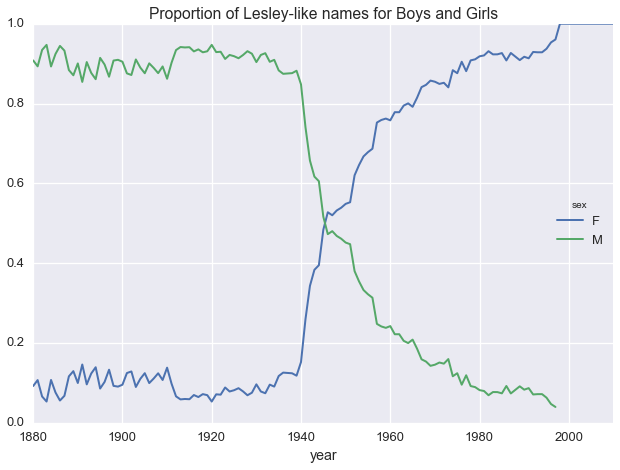

In [198]:
table = table.div(table.sum(1), axis=0)
print(table.tail());

# Plot of breakdown by sex over time
table.plot(title='Proportion of Lesley-like names for Boys and Girls')